In [1]:
import pandas as pd
pd.options.display.max_columns=200
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.pipeline import make_pipeline
import bs4 as bs
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from wordcloud import WordCloud
from PIL import Image
from pandarallel import pandarallel
import re

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import glob


#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

2023-05-02 12:23:59.401369: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 12:23:59.530846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 12:23:59.996748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-02 12:24:00.320597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

In [3]:
data_bow = pd.read_csv('data/data_bow.csv')

In [4]:
data_bow.head()

,Id,Body,Title,Tags,text
0,40101130,consider pd.series import panda import numpy n...,calculate rolling idxmax,"['python', 'pandas', 'numpy', 'dataframe', 'se...",calculate rolling idxmax consider pd.series...
1,662383,'ve using time substring str_col patindex str_...,better technique trimming leading zero sql server,"['sql', 'sql-server', 'sql-server-2005', 'tsql...",better technique trimming leading zero sql ser...
2,662421,trying install java application linux machine ...,x11 display variable mean,"['java', 'linux', 'variables', 'x11', 'headless']",x11 display variable mean trying install ja...
3,3520133,library allows easily conveniently create obje...,object oriented callback,"['c++', 'oop', 'callback', 'pointer-to-member'...",object oriented callback library allows eas...
4,1396164,edit whole question unclear want use openssl.n...,why n't .net find openssl.net dll,"['c#', '.net', 'dll', 'dllimport', 'dllnotfoun...",why n't .net find openssl.net dll edit whol...


In [5]:
import ast

# Transformer les chaînes de caractères en listes de tags
data_bow['Tags'] = data_bow['Tags'].apply(lambda x: ast.literal_eval(x))
data_bow['Tags'].head()

0          [python, pandas, numpy, dataframe, series]
1    [sql, sql-server, sql-server-2005, tsql, string]
2             [java, linux, variables, x11, headless]
3     [c++, oop, callback, pointer-to-member, eiffel]
4    [c#, .net, dll, dllimport, dllnotfoundexception]
Name: Tags, dtype: object

In [6]:
#Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_bow[['Title','Body','text']], data_bow[['Tags']], test_size=0.2, random_state=42)

In [7]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.9, min_df=2)
ctf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)

cv_fit = cvect.fit(X_train['Title'])
ctf_fit = ctf.fit(X_train['Title'])

cv_transform_title = cv_fit.transform(X_train['Title'])
ctf_transform_title = ctf.transform(X_train['Title'])

cv_transform_text = cvect.transform(X_train['text'])
ctf_transform_text = ctf.transform(X_train['text'])

In [8]:
cv_transform_title.shape, ctf_transform_title.shape

((40000, 9073), (40000, 9073))

In [9]:
cv_transform_text.shape, ctf_transform_text.shape

((40000, 9073), (40000, 9073))

In [10]:
#type of cv_transform_title
type(cv_transform_title)

scipy.sparse._csr.csr_matrix

In [11]:
cv_fit.vocabulary_.get('python')

6209

In [12]:
#Classement des mots les plus fréquents

cv_sum = cv_transform_title.sum(axis=0)
cv_words_freq = [(word, cv_sum[0, idx]) for word, idx in cv_fit.vocabulary_.items()]
cv_words_freq =sorted(cv_words_freq, key = lambda x: x[1], reverse=True)
cv_words_freq[:10]

[('using', 3088),
 ('file', 2062),
 ('use', 1531),
 ('error', 1483),
 ('net', 1477),
 ('android', 1367),
 ('java', 1296),
 ('python', 1279),
 ('data', 1051),
 ('window', 987)]

In [13]:
"""def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words_titles = gen_words(X_train['Title'])

print (data_words_titles[0:5])"""

"def gen_words(texts):\n    final = []\n    for text in texts:\n        new = gensim.utils.simple_preprocess(text, deacc=True)\n        final.append(new)\n    return (final)\n\ndata_words_titles = gen_words(X_train['Title'])\n\nprint (data_words_titles[0:5])"

In [14]:
"""data_words = gen_words(X_train['text'])
print (data_words[0][0:20])"""

"data_words = gen_words(X_train['text'])\nprint (data_words[0][0:20])"

In [15]:
from gensim.matutils import Sparse2Corpus

gensim_corpus_title_cv = Sparse2Corpus(cv_transform_title, documents_columns=False)
gensim_corpus_text_cv = Sparse2Corpus(cv_transform_text, documents_columns=False)
gensim_corpus_title_ctf = Sparse2Corpus(ctf_transform_title, documents_columns=False)
gensim_corpus_text_ctf = Sparse2Corpus(ctf_transform_text, documents_columns=False)

In [16]:
id2word_title_cv = {v: k for k, v in cv_fit.vocabulary_.items()}
id2word_title_cv = gensim.corpora.Dictionary.from_corpus(gensim_corpus_title_cv, id2word=id2word_title_cv)

id2word_text_cv = {v: k for k, v in cv_fit.vocabulary_.items()}
id2word_text_cv = gensim.corpora.Dictionary.from_corpus(gensim_corpus_text_cv, id2word=id2word_text_cv)

id2word_title_ctf = {v: k for k, v in ctf_fit.vocabulary_.items()}
id2word_title_ctf = gensim.corpora.Dictionary.from_corpus(gensim_corpus_title_ctf, id2word=id2word_title_ctf)

id2word_text_ctf = {v: k for k, v in ctf_fit.vocabulary_.items()}
id2word_text_ctf = gensim.corpora.Dictionary.from_corpus(gensim_corpus_text_ctf, id2word=id2word_text_ctf)

In [17]:
def convert_corpus_to_texts(corpus, id2word):
    texts = []
    for doc in corpus:
        text = [id2word[word_id] for word_id, freq in doc]
        texts.append(text)
    return texts

converted_title_cv = convert_corpus_to_texts(gensim_corpus_title_cv, id2word_title_cv)
converted_title_ctf = convert_corpus_to_texts(gensim_corpus_title_ctf, id2word_title_ctf)
converted_text_cv = convert_corpus_to_texts(gensim_corpus_text_cv, id2word_text_cv)
converted_text_ctf = convert_corpus_to_texts(gensim_corpus_text_ctf, id2word_text_ctf)

In [18]:
lda_model_title_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_cv,
                                           id2word=id2word_title_cv,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title_cv, gensim_corpus_title_cv, id2word_title_cv, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.013189  0.073674       1        1  13.625223
0      0.050101 -0.411528       2        1  12.317752
1     -0.365935 -0.135630       3        1  11.954182
2     -0.224896  0.382459       4        1  10.323693
8      0.332474 -0.312146       5        1  10.078504
6      0.398604 -0.039892       6        1   9.949812
3      0.099662  0.441695       7        1   9.736800
7     -0.242471 -0.382504       8        1   8.430208
4     -0.426232  0.136357       9        1   7.832143
5      0.365504  0.247515      10        1   5.751682, topic_info=          Term         Freq        Total Category  logprob  loglift
3        using  3264.000000  3264.000000  Default  30.0000  30.0000
30        file  1752.000000  1752.000000  Default  29.0000  29.0000
21         net  1500.000000  1500.000000  Default  28.0000  28.0000
306        use  1767.000000  1767.000000  Default  27.0000  27.0000
75     android  1460.000000  1460.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
318   expected   110.720640   111.676189  Topic10  -4.7373   2.8471
547   datetime   101.498125   102.453541  Topic10  -4.8242   2.8463
2186     basic   100.194611   101.150163  Topic10  -4.8372   2.8462
1363     clang    99.471989   100.427407  Topic10  -4.8444   2.8461
984     effect    91.665935    92.621393  Topic10  -4.9261   2.8453

[330 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
80        2  0.999076   access
155       5  0.998660      add
750      10  0.995133  address
1315      8  0.996806     ajax
75        7  0.999515  android
...     ...       ...      ...
460       5  0.997788  working
131       2  0.997609      wpf
224       7  0.998402    write
127       3  0.998535    xcode
410       1  0.997158      xml

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 1, 2, 3, 9, 7, 4, 8, 5, 6])

In [20]:
coherence_score_title_cv = CoherenceModel(model=lda_model_title_cv, texts=converted_title_cv, dictionary=id2word_title_cv, coherence='c_v')
coherence_score_title_cv.get_coherence()

0.29037707112940336

In [21]:
lda_model_title_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_ctf,
                                                id2word=id2word_title_ctf,
                                                num_topics=20,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_title_ctf, gensim_corpus_title_ctf, id2word_title_ctf, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.291416  0.339230       1        1  10.763669
13     0.146553 -0.352487       2        1   6.522852
17    -0.284169 -0.240220       3        1   6.413036
18    -0.131126  0.343944       4        1   6.255312
0      0.284231 -0.248171       5        1   6.083145
15     0.336859 -0.104414       6        1   6.017714
11     0.064535  0.359856       7        1   5.852930
8     -0.162545 -0.342275       8        1   5.475837
6     -0.361183  0.112668       9        1   5.444363
3      0.256337  0.155696      10        1   5.364772
1      0.348602  0.040471      11        1   5.230650
10     0.027428  0.221702      12        1   4.828370
16    -0.339504 -0.091733      13        1   4.676221
5     -0.245600  0.234535      14        1   4.255870
19    -0.006179 -0.303884      15        1   3.784543
7     -0.108824  0.083127      16        1   3.539987
9     -0.004142 -0.164774      17        1   3.362597
2     -0.208198 -0.010152      18        1   2.897137
12     0.103870 -0.030338      19        1   2.773277
4     -0.008359 -0.002780      20        1   0.457717, topic_info=         Term         Freq        Total Category  logprob  loglift
3       using  2090.000000  2090.000000  Default  30.0000  30.0000
306       use  1278.000000  1278.000000  Default  29.0000  29.0000
30       file  1301.000000  1301.000000  Default  28.0000  28.0000
96     python  1087.000000  1087.000000  Default  27.0000  27.0000
75    android  1145.000000  1145.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1041     node     0.032206     2.581701  Topic20  -9.4414   1.0026
451       run     0.032206     2.582903  Topic20  -9.4414   1.0022
542      code     0.032206     2.582865  Topic20  -9.4414   1.0022
617    custom     0.032206     2.582252  Topic20  -9.4414   1.0024
1291    video     0.032206     2.581657  Topic20  -9.4414   1.0026

[1144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
200      16  0.932698   abstract
80        1  0.993874     access
155      10  0.993497        add
262       9  0.906073     advice
27       15  0.979760  algorithm
...     ...       ...        ...
131      15  0.991435        wpf
224       4  0.993143      write
127      14  0.990028      xcode
410      17  0.987999        xml
361      18  0.962320       zoom

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 18, 19, 1, 16, 12, 9, 7, 4, 2, 11, 17, 6, 20, 8, 10, 3, 13, 5])

In [23]:
coherence_score_title_ctf = CoherenceModel(model=lda_model_title_ctf, texts=converted_title_ctf, dictionary=id2word_title_ctf, coherence='c_v')
coherence_score_title_ctf.get_coherence()

0.3888885132931495

In [24]:
lda_model_text_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_cv,
                                                id2word=id2word_text_cv,
                                                num_topics=10,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_text_cv, gensim_corpus_text_cv, id2word_text_cv, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.404660  0.094586       1        1  20.922577
2     -0.015618  0.146567       2        1  12.972136
7     -0.221469  0.328038       3        1  12.666011
0      0.197741 -0.177941       4        1  11.431670
8      0.433992 -0.084412       5        1   9.312802
6      0.337073  0.238289       6        1   8.939966
9      0.087998  0.448042       7        1   7.063330
3      0.124459 -0.473558       8        1   5.813828
1     -0.405904 -0.252008       9        1   5.587720
4     -0.133613 -0.267603      10        1   5.289961, topic_info=         Term          Freq         Total Category  logprob  loglift
67       java  27840.000000  27840.000000  Default  30.0000  30.0000
30       file  26498.000000  26498.000000  Default  29.0000  29.0000
696       org  20061.000000  20061.000000  Default  28.0000  28.0000
75    android  21631.000000  21631.000000  Default  27.0000  27.0000
257    string  21865.000000  21865.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
4706      yes   1167.870950   1844.170997  Topic10  -5.1706   2.4825
117      size   1664.586591   6944.948377  Topic10  -4.8162   1.5109
295    import   1345.486160  11354.072385  Topic10  -5.0290   0.8065
659       var   1247.184430  10712.449937  Topic10  -5.1049   0.7888
902    return   1198.349501  19670.440286  Topic10  -5.1448   0.1412

[539 rows x 6 columns], token_table=      Topic      Freq Term
term                      
7945      3  0.999908   00
1798      9  0.998811   04
2263      8  0.049168   10
2263      9  0.950843   10
3143      9  0.999801   12
...     ...       ...  ...
5686      8  0.998225  xsd
4856      4  0.999560  xxx
4706      1  0.259737  yes
4706      9  0.106823  yes
4706     10  0.633347  yes

[869 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 1, 9, 7, 10, 4, 2, 5])

In [26]:
CoherenceModel(model=lda_model_text_cv, texts=converted_text_cv, dictionary=id2word_text_cv, coherence='c_v').get_coherence()

0.5527363911348151

In [27]:
lda_model_text_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_ctf,
                                                id2word=id2word_text_ctf,
                                                num_topics=10,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_text_ctf, gensim_corpus_text_ctf, id2word_text_ctf, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.303965 -0.297015       1        1  38.026570
3      0.068115 -0.446536       2        1  33.246386
2     -0.443065  0.046280       3        1  18.907944
0     -0.188773  0.395131       4        1   3.971293
1      0.333772 -0.142528       5        1   1.509269
7      0.339397  0.122963       6        1   1.289681
4      0.161162  0.311392       7        1   1.234095
9      0.014175 -0.149114       8        1   1.011319
6     -0.057564  0.125347       9        1   0.633256
5      0.076746  0.034080      10        1   0.170186, topic_info=            Term        Freq       Total Category  logprob  loglift
471          com  694.000000  694.000000  Default  30.0000  30.0000
49        server  540.000000  540.000000  Default  29.0000  29.0000
367         date  199.000000  199.000000  Default  28.0000  28.0000
67          java  513.000000  513.000000  Default  27.0000  27.0000
58         class  924.000000  924.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8663    difftool    0.027746    1.019840  Topic10  -9.4367   2.7717
9044  routerlink    0.027765    1.092757  Topic10  -9.4361   2.7033
8672        6379    0.027820    1.352736  Topic10  -9.4341   2.4919
1408     polymer    0.027832    3.063601  Topic10  -9.4336   1.6749
8634         lan    0.027785    1.394309  Topic10  -9.4353   2.4604

[462 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2088      9  0.975122      000
1958      3  0.995724      100
6307      9  0.952397      127
1083      5  0.984793     2008
4155      8  0.951802     2009
...     ...       ...      ...
98        1  0.857563     work
98        2  0.140775     work
460       2  0.998293  working
131       9  0.993659      wpf
3279      3  0.996219      www

[360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 3, 1, 2, 8, 5, 10, 7, 6])

In [29]:
CoherenceModel(model=lda_model_text_ctf, texts=converted_text_ctf, dictionary=id2word_text_ctf, coherence='c_v').get_coherence()

0.3242731928676607

In [30]:
"""lda_models_title_cv = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
    lda_model_title_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_cv,
                                                id2word=id2word_title_cv,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models_title_cv[i] = lda_model_title_cv
    lda_model_title_cv.save('models/lda_model_title_cv_{}.model'.format(i))"""

'lda_models_title_cv = {}  # Initialise un dictionnaire vide.\n\nfor i in range(5, 25):\n    lda_model_title_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_cv,\n                                                id2word=id2word_title_cv,\n                                                num_topics=i,\n                                                random_state=100,\n                                                update_every=1,\n                                                chunksize=100,\n                                                passes=10,\n                                                alpha="auto")\n\n    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé\n    lda_models_title_cv[i] = lda_model_title_cv\n    lda_model_title_cv.save(\'models/lda_model_title_cv_{}.model\'.format(i))'

In [31]:
#load model from disk
lda_model_title_cv = {}
for i in range(5, 25):
      lda_model_title_cv[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_title_cv_{}.model'.format(i))

coherence_values_title_cv = {}
for i in range(5, 25):
      coherence_values_title_cv[i] = CoherenceModel(model=lda_model_title_cv[i], texts=converted_title_cv, dictionary=id2word_title_cv, coherence='c_v').get_coherence()

for m, cv in coherence_values_title_cv.items():
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2152
Num Topics = 6  has Coherence Value of 0.2375
Num Topics = 7  has Coherence Value of 0.2429
Num Topics = 8  has Coherence Value of 0.2501
Num Topics = 9  has Coherence Value of 0.2732
Num Topics = 10  has Coherence Value of 0.2904
Num Topics = 11  has Coherence Value of 0.3137
Num Topics = 12  has Coherence Value of 0.3227
Num Topics = 13  has Coherence Value of 0.3294
Num Topics = 14  has Coherence Value of 0.3544
Num Topics = 15  has Coherence Value of 0.3415
Num Topics = 16  has Coherence Value of 0.4001
Num Topics = 17  has Coherence Value of 0.4249
Num Topics = 18  has Coherence Value of 0.4211
Num Topics = 19  has Coherence Value of 0.3907
Num Topics = 20  has Coherence Value of 0.3898
Num Topics = 21  has Coherence Value of 0.3875
Num Topics = 22  has Coherence Value of 0.3967
Num Topics = 23  has Coherence Value of 0.4254
Num Topics = 24  has Coherence Value of 0.3854


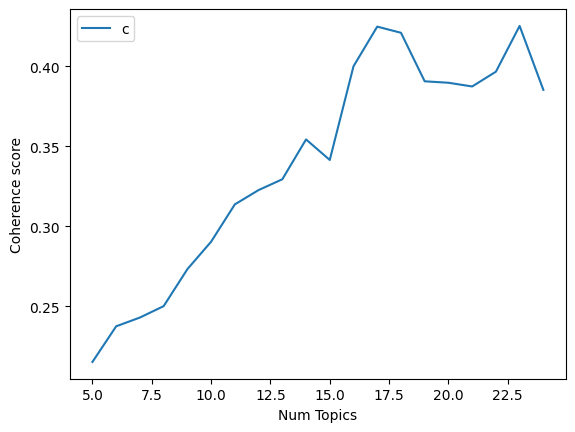

In [32]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, list(coherence_values_title_cv.values()))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
"""lda_models_title_ctf = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
      lda_model_title_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_ctf,
                                                      id2word=id2word_title_ctf,
                                                      num_topics=i,
                                                      random_state=100,
                                                      update_every=1,
                                                      chunksize=100,
                                                      passes=10,
                                                      alpha="auto")
      
      # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
      lda_models_title_ctf[i] = lda_model_title_ctf
      lda_model_title_ctf.save('models/lda_model_title_ctf_{}.model'.format(i))"""

'lda_models_title_ctf = {}  # Initialise un dictionnaire vide.\n\nfor i in range(5, 25):\n      lda_model_title_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_title_ctf,\n                                                      id2word=id2word_title_ctf,\n                                                      num_topics=i,\n                                                      random_state=100,\n                                                      update_every=1,\n                                                      chunksize=100,\n                                                      passes=10,\n                                                      alpha="auto")\n      \n      # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé\n      lda_models_title_ctf[i] = lda_model_title_ctf\n      lda_model_title_ctf.save(\'models/lda_model_title_ctf_{}.model\'.format(i))'

In [34]:
#load model from disk
lda_model_title_ctf = {}
for i in range(5, 25):
      lda_model_title_ctf[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_title_ctf_{}.model'.format(i))

coherence_values_title_ctf = {}
for i in range(5, 25):
      coherence_values_title_ctf[i] = CoherenceModel(model=lda_model_title_ctf[i], texts=converted_title_ctf, dictionary=id2word_title_ctf, coherence='c_v').get_coherence()

for m, cv in coherence_values_title_ctf.items():
      print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2194
Num Topics = 6  has Coherence Value of 0.284
Num Topics = 7  has Coherence Value of 0.2557
Num Topics = 8  has Coherence Value of 0.2945
Num Topics = 9  has Coherence Value of 0.3622
Num Topics = 10  has Coherence Value of 0.3086
Num Topics = 11  has Coherence Value of 0.352
Num Topics = 12  has Coherence Value of 0.3588
Num Topics = 13  has Coherence Value of 0.3515
Num Topics = 14  has Coherence Value of 0.3592
Num Topics = 15  has Coherence Value of 0.4441
Num Topics = 16  has Coherence Value of 0.4528
Num Topics = 17  has Coherence Value of 0.4084
Num Topics = 18  has Coherence Value of 0.3731
Num Topics = 19  has Coherence Value of 0.3673
Num Topics = 20  has Coherence Value of 0.3889
Num Topics = 21  has Coherence Value of 0.3417
Num Topics = 22  has Coherence Value of 0.3528
Num Topics = 23  has Coherence Value of 0.3552
Num Topics = 24  has Coherence Value of 0.3375


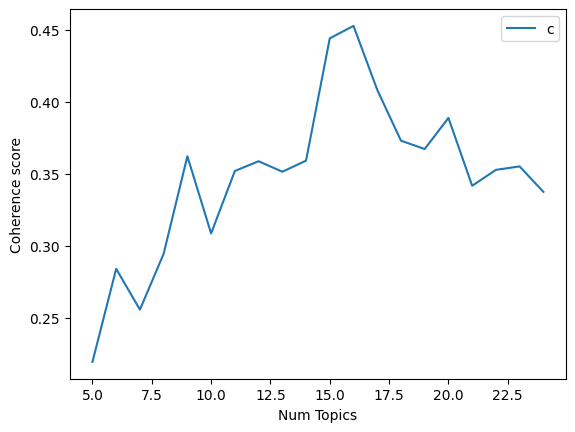

In [35]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, list(coherence_values_title_ctf.values()))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
"""lda_models_text_cv = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
    lda_model_text_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_cv,
                                                id2word=id2word_text_cv,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models_text_cv[i] = lda_model_text_cv
    lda_model_text_cv.save('models/lda_model_text_cv_{}.model'.format(i))"""

'lda_models_text_cv = {}  # Initialise un dictionnaire vide.\n\nfor i in range(5, 25):\n    lda_model_text_cv = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_cv,\n                                                id2word=id2word_text_cv,\n                                                num_topics=i,\n                                                random_state=100,\n                                                update_every=1,\n                                                chunksize=100,\n                                                passes=10,\n                                                alpha="auto")\n\n    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé\n    lda_models_text_cv[i] = lda_model_text_cv\n    lda_model_text_cv.save(\'models/lda_model_text_cv_{}.model\'.format(i))'

In [37]:
#load models from disk
lda_models_text_cv = {}
for i in range(5, 25):
      lda_models_text_cv[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_text_cv_{}.model'.format(i))

In [38]:
coherence_values_text_cv = []
for i in range(5, 25):
      model = lda_models_text_cv[i]
      coherence_model = CoherenceModel(model=model, texts=converted_text_cv, dictionary=id2word_text_cv, coherence='c_v')
      coherence_values_text_cv.append(coherence_model.get_coherence())

In [39]:
for m, cv in zip(range(5, 25), coherence_values_text_cv):
      print("Num Topics =", m, "has Coherence Value of", round(cv, 4))

Num Topics = 5 has Coherence Value of 0.5055
Num Topics = 6 has Coherence Value of 0.5215
Num Topics = 7 has Coherence Value of 0.5002
Num Topics = 8 has Coherence Value of 0.5669
Num Topics = 9 has Coherence Value of 0.5229
Num Topics = 10 has Coherence Value of 0.5527
Num Topics = 11 has Coherence Value of 0.5377
Num Topics = 12 has Coherence Value of 0.5235
Num Topics = 13 has Coherence Value of 0.5478
Num Topics = 14 has Coherence Value of 0.5123
Num Topics = 15 has Coherence Value of 0.5284
Num Topics = 16 has Coherence Value of 0.55
Num Topics = 17 has Coherence Value of 0.5046
Num Topics = 18 has Coherence Value of 0.5071
Num Topics = 19 has Coherence Value of 0.513
Num Topics = 20 has Coherence Value of 0.4887
Num Topics = 21 has Coherence Value of 0.5078
Num Topics = 22 has Coherence Value of 0.4898
Num Topics = 23 has Coherence Value of 0.4779
Num Topics = 24 has Coherence Value of 0.4832


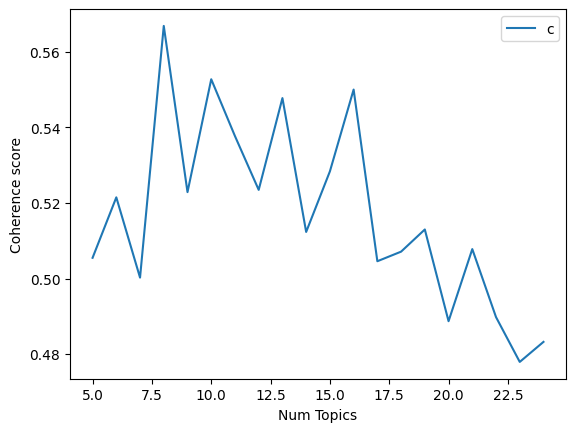

In [40]:
#plot coherence score
x = range(5, 25)
plt.plot(x, coherence_values_text_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
"""lda_models_text_ctf = {}  # Initialise un dictionnaire vide.

for i in range(5, 25):
    lda_model_text_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_ctf,
                                                id2word=id2word_text_ctf,
                                                num_topics=i,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")

    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé
    lda_models_text_ctf[i] = lda_model_text_ctf
    lda_model_text_ctf.save('models/lda_model_text_ctf_{}.model'.format(i))"""

'lda_models_text_ctf = {}  # Initialise un dictionnaire vide.\n\nfor i in range(5, 25):\n    lda_model_text_ctf = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_text_ctf,\n                                                id2word=id2word_text_ctf,\n                                                num_topics=i,\n                                                random_state=100,\n                                                update_every=1,\n                                                chunksize=100,\n                                                passes=10,\n                                                alpha="auto")\n\n    # Enregistre le modèle dans le dictionnaire avec le nombre de sujets comme clé\n    lda_models_text_ctf[i] = lda_model_text_ctf\n    lda_model_text_ctf.save(\'models/lda_model_text_ctf_{}.model\'.format(i))'

Num Topics = 5 has Coherence Value of 0.3401
Num Topics = 6 has Coherence Value of 0.3482
Num Topics = 7 has Coherence Value of 0.2919
Num Topics = 8 has Coherence Value of 0.3952
Num Topics = 9 has Coherence Value of 0.2927
Num Topics = 10 has Coherence Value of 0.3243
Num Topics = 11 has Coherence Value of 0.2912
Num Topics = 12 has Coherence Value of 0.2858
Num Topics = 13 has Coherence Value of 0.3047
Num Topics = 14 has Coherence Value of 0.29
Num Topics = 15 has Coherence Value of 0.2579
Num Topics = 16 has Coherence Value of 0.2711
Num Topics = 17 has Coherence Value of 0.2845
Num Topics = 18 has Coherence Value of 0.2776
Num Topics = 19 has Coherence Value of 0.2692
Num Topics = 20 has Coherence Value of 0.267
Num Topics = 21 has Coherence Value of 0.2799
Num Topics = 22 has Coherence Value of 0.2831
Num Topics = 23 has Coherence Value of 0.2665
Num Topics = 24 has Coherence Value of 0.2738


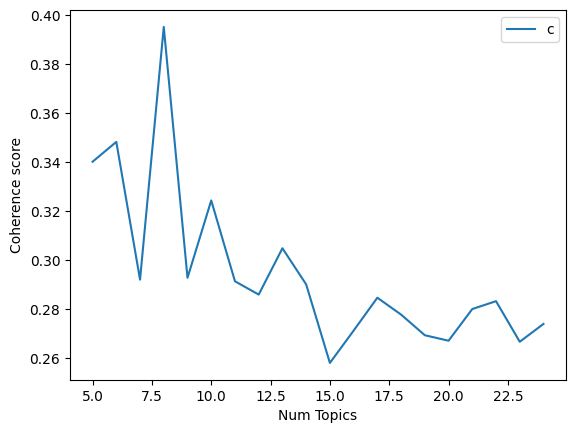

In [42]:
#load models from disk
lda_models_text_ctf = {}
for i in range(5, 25):
      lda_models_text_ctf[i] = gensim.models.ldamodel.LdaModel.load('models/lda_model_text_ctf_{}.model'.format(i))


coherence_values_text_ctf = []
for i in range(5, 25):
      model = lda_models_text_ctf[i]
      coherence_model = CoherenceModel(model=model, texts=converted_text_ctf, dictionary=id2word_text_ctf, coherence='c_v')
      coherence_values_text_ctf.append(coherence_model.get_coherence())


for m, cv in zip(range(5, 25), coherence_values_text_ctf):
      print("Num Topics =", m, "has Coherence Value of", round(cv, 4))



#plot coherence score
x = range(5, 25)
plt.plot(x, coherence_values_text_ctf)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
lda_model = lda_models_text_cv[8]

In [44]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, gensim_corpus_text_cv, id2word_text_cv)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.034510  0.129733       1        1  25.687626
7      0.175236  0.033605       2        1  13.371217
2      0.172523 -0.056429       3        1  13.034690
6      0.008929  0.269991       4        1  11.025654
3     -0.146261  0.112198       5        1   9.744048
4      0.238977 -0.197945       6        1   9.698978
1     -0.188426 -0.236866       7        1   9.230328
0     -0.295487 -0.054288       8        1   8.207459, topic_info=        Term          Freq         Total Category  logprob  loglift
67      java  27982.000000  27982.000000  Default  30.0000  30.0000
30      file  25794.000000  25794.000000  Default  29.0000  29.0000
696      org  20164.000000  20164.000000  Default  28.0000  28.0000
75   android  21451.000000  21451.000000  Default  27.0000  27.0000
257   string  21744.000000  21744.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
830      web   3447.043745   8903.444197   Topic8  -4.5275   1.5512
4    package   2864.200046   5618.550527   Topic8  -4.7127   1.8263
790   source   2864.144798   6087.436362   Topic8  -4.7127   1.7462
451      run   3193.941957  12456.231430   Topic8  -4.6037   1.1392
5      debug   2409.164438   4121.082919   Topic8  -4.8857   1.9633

[458 rows x 6 columns], token_table=      Topic      Freq Term
term                      
7945      7  0.999839   00
1798      7  0.999431   04
2263      7  0.900814   10
2263      8  0.099001   10
3143      7  0.999532   12
...     ...       ...  ...
410       3  0.041816  xml
410       4  0.177332  xml
410       8  0.780843  xml
4856      5  0.941086  xxx
4856      8  0.058571  xxx

[738 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 3, 7, 4, 5, 2, 1])

In [45]:
Mtopics_words = lda_model.get_topics()

In [46]:
Mtopics_words.shape

(8, 9073)

In [47]:
Mtrain_quest_topics = [lda_model.get_document_topics(doc) for doc in gensim_corpus_text_cv]

In [48]:
Mtrain_quest_topics_matrix = np.zeros((len(Mtrain_quest_topics), lda_model.num_topics))

for i, doc_topics in enumerate(Mtrain_quest_topics):
    for topic, prob in doc_topics:
        Mtrain_quest_topics_matrix[i, topic] = prob

Mtrain_quest_words = np.dot(Mtrain_quest_topics_matrix, Mtopics_words)

In [49]:
cv_transform_text_test = cv_fit.transform(X_test['text'])
gensim_corpus_text_test = Sparse2Corpus(cv_transform_text_test, documents_columns=False)

In [50]:
Mtest_quest_topics = [lda_model.get_document_topics(doc) for doc in gensim_corpus_text_test]

In [51]:
Mtest_quest_topics_matrix = np.zeros((len(Mtest_quest_topics), lda_model.num_topics))

for i, doc_topics in enumerate(Mtest_quest_topics):
    for topic, prob in doc_topics:
        Mtest_quest_topics_matrix[i, topic] = prob

Mtest_quest_words = np.dot(Mtest_quest_topics_matrix, Mtopics_words)

In [52]:
threshold = 0.01
Mtrain_quest_words[Mtrain_quest_words < threshold] = 0
Mtest_quest_words[Mtest_quest_words < threshold] = 0

In [53]:
topic_word_matrix = lda_model.get_topics()
topic_word_df = pd.DataFrame(topic_word_matrix, columns=cv_fit.get_feature_names_out())

In [54]:
train_quest_topics = lda_model.get_document_topics(gensim_corpus_text_cv, minimum_probability=0)
train_quest_topics_matrix = np.zeros((len(X_train), lda_model.num_topics))

for i, topic_probs in enumerate(train_quest_topics):
    for topic, prob in topic_probs:
        train_quest_topics_matrix[i, topic] = prob

train_quest_topics_df = pd.DataFrame(train_quest_topics_matrix)


In [55]:
test_quest_topics = lda_model.get_document_topics(gensim_corpus_text_test, minimum_probability=0)
test_quest_topics_matrix = np.zeros((len(X_test), lda_model.num_topics))

for i, topic_probs in enumerate(test_quest_topics):
    for topic, prob in topic_probs:
        test_quest_topics_matrix[i, topic] = prob

test_quest_topics_df = pd.DataFrame(test_quest_topics_matrix)

In [56]:
topics_words_matrix = lda_model.get_topics()
train_quest_words_matrix = np.matmul(train_quest_topics_df, topics_words_matrix)
test_quest_words_matrix = np.matmul(test_quest_topics_df, topics_words_matrix)

In [57]:
n_top_words = 5
train_quest_words_matrix_np = train_quest_words_matrix.to_numpy()
test_quest_words_matrix_np = test_quest_words_matrix.to_numpy()

train_keywords_indices = train_quest_words_matrix_np.argsort(axis=1)[:, -n_top_words:]
test_keywords_indices = test_quest_words_matrix_np.argsort(axis=1)[:, -n_top_words:]

In [58]:
train_keywords = [[id2word_text_cv[i] for i in keyword_indices] for keyword_indices in train_keywords_indices]
test_keywords = [[id2word_text_cv [i] for i in keyword_indices] for keyword_indices in test_keywords_indices]

In [59]:
import random

def display_keywords(questions, keywords, real_tags, num_samples=10):
    sample_indices = random.sample(range(len(questions)), num_samples)
    for idx in sample_indices:
        print("Question:", questions.iloc[idx])
        print("Mots-clés:", keywords[idx])
        print("Tags réels:", real_tags.iloc[idx])
        print("\n")

# Vérifier les mots-clés pour l'ensemble d'entraînement
print("Échantillon de l'ensemble d'entraînement :\n")
display_keywords(X_train['text'], train_keywords, y_train['Tags'])

Échantillon de l'ensemble d'entraînement :

Question: docker network affecting host network container restart err_network_changed chrome    facing weird issue docker network using external bridge network named extenal_network docker container auto restart enabled able access host network container restarting due error maybe code infra related please refer attached screenshot clarity 've tried link luck superuser.com question 1336567 installing docker ubuntu break internet connectivity host success.docker.com article influence network address range docker chooses docker network create forums.docker.com cant access internet installing docker fresh ubuntu machine 53416 superuser.com question 747735 regularly getting err network changed error chrome 773971 dockerfile from node:10.20.1 alpine run apk add cache python make workdir home app copy package.json package lock.json run npm install copy docker compose version service app container_name app build context dockerfile dockerfile image '

In [60]:
# Vérifier les mots-clés pour l'ensemble de test
print("Échantillon de l'ensemble de test :\n")
display_keywords(X_test['text'], test_keywords, y_test['Tags'])

Échantillon de l'ensemble de test :

Question: stream large file line line    10gb csv file like use seed running ror application heroku n't figure stream csv line line process way large fit memory n't use file.open access external file 've looked using tempfile stream byte time n't match new line reconstructing ruby difficult thank
Mots-clés: ['use', 'line', 'using', 'error', 'file']
Tags réels: ['ruby', 'heroku', 'amazon-s3', 'io', 'large-files']


Question: way implement algebraic type java    possible java enforce class specific set subclass others for example public abstract class public final class extends public final class extends public final class extends can somehow enforce subclass ever created
Mots-clés: ['object', 'new', 'public', 'string', 'class']
Tags réels: ['java', 'class', 'abstract-class', 'final', 'adts']


Question: backup mysql user    how backup mysql user privilege anything like mysqldump looking something like mysqldump root mytable schema.sql
Mots-clés: ['li

In [61]:
def coverage_rate(real_tags, generated_tags):
    intersection_count = 0
    total_count = 0
    
    for idx in range(len(real_tags)):
        real_tag_set = set(real_tags.iloc[idx])
        generated_tag_set = set(generated_tags[idx])
        
        intersection = real_tag_set.intersection(generated_tag_set)
        intersection_count += len(intersection)
        total_count += len(real_tag_set)
        
    coverage = intersection_count / total_count
    return coverage

# Calculer le taux de couverture des tags réels pour l'ensemble d'entraînement
coverage = coverage_rate(y_train['Tags'], train_keywords)
print("Taux de couverture des tags réels sur les données d'entraînement :", coverage)


# Calculer le taux de couverture des tags réels pour l'ensemble de test
coverage = coverage_rate(y_test['Tags'], test_keywords)
print("Taux de couverture des tags réels sur les données de test :", coverage)

Taux de couverture des tags réels sur les données d'entraînement : 0.026304736952630473
Taux de couverture des tags réels sur les données de test : 0.02548


In [62]:
def common_tag_rate(real_tags, generated_tags):
    common_tag_count = 0
    
    for idx in range(len(real_tags)):
        real_tag_set = set(real_tags.iloc[idx])
        generated_tag_set = set(generated_tags[idx])
        
        intersection = real_tag_set.intersection(generated_tag_set)
        
        if len(intersection) > 0:
            common_tag_count += 1
            
    rate = common_tag_count / len(real_tags)
    return rate

# Calculer le taux de prédictions ayant au moins un tag en commun avec les tags réels pour l'ensemble d'entraînement
train_common_tag_rate = common_tag_rate(y_train['Tags'], train_keywords)
print("Taux de prédictions ayant au moins un tag en commun avec les tags réels (entraînement) :", train_common_tag_rate)

# Calculer le taux de prédictions ayant au moins un tag en commun avec les tags réels pour l'ensemble de test
test_common_tag_rate = common_tag_rate(y_test['Tags'], test_keywords)
print("Taux de prédictions ayant au moins un tag en commun avec les tags réels (test) :", test_common_tag_rate)

Taux de prédictions ayant au moins un tag en commun avec les tags réels (entraînement) : 0.1264
Taux de prédictions ayant au moins un tag en commun avec les tags réels (test) : 0.1227


Partie 2: Modèle supervisé

In [63]:
data_bow['Tags']

0               [python, pandas, numpy, dataframe, series]
1         [sql, sql-server, sql-server-2005, tsql, string]
2                  [java, linux, variables, x11, headless]
3          [c++, oop, callback, pointer-to-member, eiffel]
4         [c#, .net, dll, dllimport, dllnotfoundexception]
                               ...                        
49995              [c#, .net, clr, function-pointers, cil]
49996               [ios, swift, webrtc, ios15, videocall]
49997    [android, android-intent, warnings, logcat, an...
49998    [graphql, apollo, react-apollo, apollo-client,...
49999    [node.js, websocket, socket.io, apollo-server,...
Name: Tags, Length: 50000, dtype: object

In [64]:
from collections import Counter

# Compter les tags
tags_counter = Counter()
for tags in data_bow['Tags']:
    tags_counter.update(tags)

# Nombre de tags différents
print("Nombre de tags différents :", len(tags_counter))

# Obtenir les 100 tags les plus fréquents
top_100_tags = tags_counter.most_common(100)
print("\nTop 100 tags les plus fréquents :")
for tag, count in top_100_tags:
    print(f"{tag}: {count}")

Nombre de tags différents : 18315

Top 100 tags les plus fréquents :
c#: 6464
java: 5846
javascript: 4876
python: 4699
c++: 3868
.net: 3488
ios: 3473
android: 3187
html: 2154
php: 2005
objective-c: 1890
jquery: 1785
iphone: 1705
c: 1592
asp.net: 1345
sql: 1337
css: 1303
linux: 1267
node.js: 1142
spring: 1051
performance: 1049
swift: 1026
windows: 1023
ruby-on-rails: 961
xcode: 931
json: 913
mysql: 911
sql-server: 887
multithreading: 843
asp.net-mvc: 805
unit-testing: 787
database: 785
ruby: 781
arrays: 771
django: 770
wpf: 760
macos: 738
visual-studio: 732
c++11: 699
reactjs: 695
algorithm: 692
string: 673
python-3.x: 592
xml: 545
ajax: 535
cocoa-touch: 518
gcc: 508
security: 503
angular: 496
eclipse: 487
hibernate: 486
typescript: 485
r: 480
postgresql: 465
spring-boot: 458
git: 457
image: 449
angularjs: 449
rest: 445
amazon-web-services: 445
winforms: 437
debugging: 436
pandas: 428
numpy: 426
bash: 423
http: 404
google-chrome: 398
authentication: 387
entity-framework: 377
testing: 37

In [65]:
top_100_tags_set = set(tag for tag, _ in top_100_tags)

# Fonction pour ne garder que les tags du top 100
def keep_top_100_tags(tags):
    return [tag for tag in tags if tag in top_100_tags_set]

# Appliquer la fonction 
data_filtered = data_bow.copy()
data_filtered['Tags'] = data_filtered['Tags'].apply(keep_top_100_tags)

# Filtrer les données pour ne garder que les questions ayant au moins un tag dans le top 100
data_filtered = data_filtered[data_filtered['Tags'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

# Afficher le nombre de questions restantes
print("Nombre de questions restantes :", len(data_filtered))

Nombre de questions restantes : 46749


In [66]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(data_filtered[['Title','text']], data_filtered['Tags'], test_size=0.2, random_state=42)

In [67]:
X_train_filtered

,Title,text
11224,atomikos data getting saved using postgresql,atomikos data getting saved using postgresql ...
43792,caching solution querying,caching solution querying are memory cachin...
20879,mariadb json support laravel,mariadb json support laravel trying create ...
5183,conda python virtual environment portable wind...,conda python virtual environment portable wind...
30327,xmpp filetransfer why bytestreams protocol fail,xmpp filetransfer why bytestreams protocol fai...
...,...,...
11284,bruijn algorithm binary digit count 64bits,bruijn algorithm binary digit count 64bits ...
44732,string comparison performance,string comparison performance there number ...
38158,read failed ebadf bad file descriptor reading ...,read failed ebadf bad file descriptor reading ...
860,javascript check mouse button,javascript check mouse button way detect mo...


In [68]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_filtered_encoded = mlb.fit_transform(y_train_filtered)
y_test_filtered_encoded = mlb.transform(y_test_filtered)

In [69]:
mlb.classes_.shape

(100,)

In [70]:
ctf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=2)
ctf_fit = ctf.fit(X_train_filtered['Title'])
ctf_text_train = ctf.transform(X_train_filtered['text'])
ctf_text_test = ctf.transform(X_test_filtered['text'])

In [104]:
len(ctf_fit.vocabulary_)

8606

In [71]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs'), n_jobs=-3)
ovr.fit(ctf_text_train, y_train_filtered_encoded)
y_pred_test_ctf = ovr.predict(ctf_text_test)

In [72]:
from sklearn.metrics import jaccard_score

score_ctf = jaccard_score(y_test_filtered_encoded, y_pred_test_ctf, average='weighted')

print("Jaccard Score ctf:", score_ctf)

Jaccard Score ctf: 0.33733448018598877


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

"""# Créer un classificateur OvR avec une régression logistique
ovr = OneVsRestClassifier(LogisticRegression())

# Créer un pipeline avec TfidfVectorizer et OneVsRestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', ovr)
])

# Définir les paramètres de la grille à optimiser
param_grid = [
    {
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__stop_words': [None, 'english'],
        'clf__estimator__C': [0.1, 1, 10],
        'clf__estimator__penalty': ['l1'],
        'clf__estimator__solver': ['liblinear', 'saga'],
    },
    {
        'tfidf__max_df': [0.9, 1.0],
        'tfidf__min_df': [1, 2],
        'tfidf__stop_words': [None, 'english'],
        'clf__estimator__C': [0.1, 1, 10],
        'clf__estimator__penalty': ['l2'],
        'clf__estimator__solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
    },
]

# Utiliser le score de Jaccard pondéré pour l'évaluation
jaccard_scorer = make_scorer(jaccard_score, average='weighted')

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring=jaccard_scorer, cv=5, n_jobs=-3)

# Ajuster la recherche par grille aux données
grid_search.fit(X_train_filtered['text'], y_train_filtered_encoded)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés:")
print(grid_search.best_params_)"""

#4h

'# Créer un classificateur OvR avec une régression logistique\novr = OneVsRestClassifier(LogisticRegression())\n\n# Créer un pipeline avec TfidfVectorizer et OneVsRestClassifier\npipeline = Pipeline([\n    (\'tfidf\', TfidfVectorizer()),\n    (\'clf\', ovr)\n])\n\n# Définir les paramètres de la grille à optimiser\nparam_grid = [\n    {\n        \'tfidf__max_df\': [0.9, 1.0],\n        \'tfidf__min_df\': [1, 2],\n        \'tfidf__stop_words\': [None, \'english\'],\n        \'clf__estimator__C\': [0.1, 1, 10],\n        \'clf__estimator__penalty\': [\'l1\'],\n        \'clf__estimator__solver\': [\'liblinear\', \'saga\'],\n    },\n    {\n        \'tfidf__max_df\': [0.9, 1.0],\n        \'tfidf__min_df\': [1, 2],\n        \'tfidf__stop_words\': [None, \'english\'],\n        \'clf__estimator__C\': [0.1, 1, 10],\n        \'clf__estimator__penalty\': [\'l2\'],\n        \'clf__estimator__solver\': [\'newton-cg\', \'lbfgs\', \'sag\', \'saga\', \'liblinear\'],\n    },\n]\n\n# Utiliser le score de J

best_params = {'clf__estimator__C': 10, 'clf__estimator__penalty': 'l1', 'clf__estimator__solver': 'liblinear', 'tfidf__max_df': 1.0, 'tfidf__min_df': 1, 'tfidf__stop_words': 'english'}

In [74]:
# Appliquer les meilleurs paramètres pour TfidfVectorizer
tfidf = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english')

# Transformer les données d'entraînement et de test
X_train_tfidf = tfidf.fit_transform(X_train_filtered['text'])
X_test_tfidf = tfidf.transform(X_test_filtered['text'])

In [75]:
"""# Créer le classificateur OvR en utilisant les meilleurs paramètres
ovr_best = OneVsRestClassifier(LogisticRegression(C=10, penalty='l1', solver='liblinear'))

# Entraîner le classificateur avec les données d'entraînement transformées
ovr_best.fit(X_train_tfidf, y_train_filtered_encoded)"""

"# Créer le classificateur OvR en utilisant les meilleurs paramètres\novr_best = OneVsRestClassifier(LogisticRegression(C=10, penalty='l1', solver='liblinear'))\n\n# Entraîner le classificateur avec les données d'entraînement transformées\novr_best.fit(X_train_tfidf, y_train_filtered_encoded)"

In [76]:
"""#Sauvegarder le modèle
import pickle

pickle.dump(ovr_best, open('models/ovr_best.sav', 'wb'))"""

"#Sauvegarder le modèle\nimport pickle\n\npickle.dump(ovr_best, open('models/ovr_best.sav', 'wb'))"

In [77]:
#Charger le modèle
import pickle

ovr_best = pickle.load(open('models/ovr_best.sav', 'rb'))

In [78]:
jaccard_score(y_test_filtered_encoded, ovr_best.predict(X_test_tfidf), average='weighted')

0.460651345752161

In [79]:
text_example = X_train['text'][13]

In [80]:
text_example_tfidf = tfidf.transform(pd.Series(text_example))

In [81]:
ovr_best.predict(text_example_tfidf)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [82]:
import random
from termcolor import colored


# Utiliser predict_proba pour obtenir les probabilités des tags
y_pred_proba = ovr_best.predict_proba(X_test_tfidf)

# Obtenir les vrais tags pour les données de test
y_test_tags = mlb.inverse_transform(y_test_filtered_encoded)

# Appliquer un seuil pour les probabilités
threshold = 0.1

# Afficher les prédictions et les vrais tags pour 10 exemples pris au hasard
num_examples = 10
random_examples = random.sample(range(len(X_test_filtered)), num_examples)

for i in random_examples:
    print(f"Exemple {i + 1}:")
    print(f"Texte  : {X_test_filtered.iloc[i]['text']}")
    print(f"Vrais tags  : {' | '.join(y_test_tags[i])}")

    # Extraire les tags prédits au-dessus du seuil avec leurs probabilités
    predicted_tags_with_probs = [(mlb.classes_[j], prob) for j, prob in enumerate(y_pred_proba[i]) if prob > threshold]
    
    # Ajouter les tags réels qui ne sont pas déjà dans les tags prédits
    for tag in y_test_tags[i]:
        if tag not in [t[0] for t in predicted_tags_with_probs]:
            prob = y_pred_proba[i][mlb.classes_.tolist().index(tag)]
            predicted_tags_with_probs.append((tag, prob))

    # Trier les tags prédits et réels par popularité et les afficher avec leurs probabilités
    sorted_tags_with_probs = sorted(predicted_tags_with_probs, key=lambda x: x[1], reverse=True)
    
    colored_tags = []
    for tag, prob in sorted_tags_with_probs:
        if tag in y_test_tags[i] and prob > threshold:
            colored_tags.append(colored(f"{tag} ({prob:.3f})", 'green'))
        elif tag in y_test_tags[i]:
            colored_tags.append(colored(f"{tag} ({prob:.3f})", 'red'))
        else:
            colored_tags.append(colored(f"{tag} ({prob:.3f})", 'yellow'))
    
    sorted_tags_with_probs_str = ' | '.join(colored_tags)
    
    print(f"Tags prédits et réels  : {sorted_tags_with_probs_str}")
    print("-" * 50)

Exemple 560:
Texte  : how communicate window service application interacts desktop    with .net best way interact service i.e tray apps communicate server would preferred method would cross platform well working mono guess remoting edit forgot mention still support window 2000 machine field wcf anything .net 2.0 n't fly
Vrais tags  : .net | c#
Tags prédits et réels  : .net (0.978) | c# (0.952)
--------------------------------------------------
Exemple 5207:
Texte  : casting double array struct double    cast double array struct made double struct double double double int main int argc char argv double arr 1.0,2.0,3.0 static_cast static_cast void arr std :cout this print but guaranteed work every time compiler edit according 9.2.21 pointer standard layout struct object suitably converted using reinterpret_cast point initial member vice versa replace code struct double return data double return data double return data private double data int main int char double arr 1.0,2.0,3.0 reinterpr

In [83]:
data_se = pd.read_csv('data/data_se.csv')

In [84]:
data_se['Tags'] = data_se['Tags'].apply(lambda x: ast.literal_eval(x))
data_se['Tags'].head()

0          [python, pandas, numpy, dataframe, series]
1    [sql, sql-server, sql-server-2005, tsql, string]
2             [java, linux, variables, x11, headless]
3     [c++, oop, callback, pointer-to-member, eiffel]
4    [c#, .net, dll, dllimport, dllnotfoundexception]
Name: Tags, dtype: object

In [85]:
# Compter les tags
tags_counter = Counter()
for tags in data_se['Tags']:
    tags_counter.update(tags)

# Nombre de tags différents
print("Nombre de tags différents :", len(tags_counter))

# Obtenir les 100 tags les plus fréquents
top_100_tags = tags_counter.most_common(100)

Nombre de tags différents : 18315


In [86]:
top_100_tags_set = set(tag for tag, _ in top_100_tags)

# Fonction pour ne garder que les tags du top 100
def keep_top_100_tags(tags):
    return [tag for tag in tags if tag in top_100_tags_set]

# Appliquer la fonction 
data_se_filtered = data_se.copy()
data_se_filtered['Tags'] = data_se_filtered['Tags'].apply(keep_top_100_tags)

# Filtrer les données pour ne garder que les questions ayant au moins un tag dans le top 100
data_se_filtered = data_se_filtered[data_se_filtered['Tags'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

# Afficher le nombre de questions restantes
print("Nombre de questions restantes :", len(data_se_filtered))

Nombre de questions restantes : 46749


In [87]:
X_train_se, X_test_se, y_train_se, y_test_se = train_test_split(data_se_filtered[['Title','Body']], data_se_filtered['Tags'], test_size=0.2, random_state=0)

In [93]:
X_train_se

,Title,Body
30012,crazy rounded rect uibezierpath behavior on io...,the simple uiview below draws a rounded rectan...
8923,find count of files matching a pattern in a di...,i am new to linux . i have a directory in linu...
8839,how to get git log with short stat in one line ?,following command outputs following lines of t...
7844,can placement new for arrays be used in a port...,is it possible to actually make use of placeme...
42810,ie & drop down menus triggering the pop up blo...,i have no idea why this is happening . i have ...
...,...,...
21243,reading a file from a hard drive in iphone sim...,is it possible to read a file ( from my normal...
45891,"why is pow ( infinity , positive non integer )...",c99 annex f ( ieee floating point support ) sa...
42613,java.util.concurrentlinkedqueue,i want to use java.util.concurrentlinkedqueue ...
43567,append line to etc hosts file with shell script,i have a new ubuntu 12.04 vps . i am trying to...


In [90]:
from gensim.models import KeyedVectors

# Charger le modèle pré-entraîné
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [100]:
word = "java"
similar_words = model.most_similar(positive=[word], topn=5)
print(f"Les 5 mots les plus similaires à '{word}':")
for similar_word, similarity in similar_words:
    print(f"{similar_word} (similarité: {similarity:.2f})")

Les 5 mots les plus similaires à 'java':
coffee (similarité: 0.65)
o_joe (similarité: 0.63)
chai_latte (similarité: 0.58)
joe (similarité: 0.58)
espresso (similarité: 0.57)


In [92]:
def get_embeddings(question_tokenized, word2vec_model):
    embeddings = []
    for word in question_tokenized:
        try:
            # Obtenir l'embedding du mot à partir du modèle Word2Vec
            word_embedding = word2vec_model[word]
            # Ajouter l'embedding à la liste des embeddings
            embeddings.append(word_embedding)
        except KeyError:
            # Si le mot n'est pas dans le vocabulaire du modèle, ignorer ce mot
            pass
    return embeddings

In [94]:
def get_embeddings(tokenized_words, model):
    embeddings = []
    for word in tokenized_words:
        try:
            word_embedding = model[word]
            embeddings.append(word_embedding)
        except KeyError:
            # Si le mot n'est pas dans le modèle pré-entraîné, vous pouvez ignorer le mot ou utiliser un vecteur de zéros
            # embeddings.append(np.zeros(model.vector_size))
            pass
    return np.mean(embeddings, axis=0)

title_embeddings = []
text_embeddings = []

for _, row in X_train.iterrows():
    title_tokenized = row['Title']
    text_tokenized = row['text']

    title_embedding = get_embeddings(title_tokenized, model)
    text_embedding = get_embeddings(text_tokenized, model)

    title_embeddings.append(title_embedding)
    text_embeddings.append(text_embedding)


Les 5 mots les plus similaires à 'computer':
computers (similarité: 0.80)
laptop (similarité: 0.66)
laptop_computer (similarité: 0.65)
Computer (similarité: 0.65)
com_puter (similarité: 0.61)
